# Basic analysis and optimization
Francis Deck, 11-26-2022

I just want to try *something* that will test the ability of my program to optimize.

It's a success. So, what's the problem? Why doesn't this replace one of the commercial packages? The reason is that those packages provide an *extreme* number of merit function operands, whereas you have to write each one yourself here.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import opticsRayTrace.rayTraceTools as rtt
import opticsRayTrace.drawing as rtd
import time

This is a modified version of the same function from the **raytrace** notebook, but with an added feature of returning a table of field numbers, so I can separate the fields later on during analysis.

Let's define a basic starting point, a doublet of lenses with finite conjugates, and a bunch of randomly generated rays. The ray list will stay the same during analysis, only the design will change.

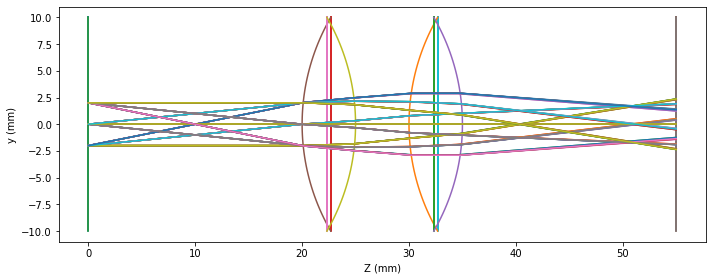

In [7]:
start_r = 20

surface_list = [
    {'surf': 'dummy', 'dist': 20, 'draw_radius': 10},
    {'surf': 'conic', 'c': 1/start_r, 'k': 0, 'material': 'N-BK7', 'dist': 5, 'draw_radius': 10},
    {'surf': 'conic', 'c': -1/start_r, 'k': 0, 'dist': 5, 'draw_radius': 10},
    {'surf': 'conic', 'c': 1/start_r, 'k': 0, 'material': 'N-BK7', 'dist': 5, 'draw_radius': 10},
    {'surf': 'conic', 'c': -1/start_r, 'k': 0, 'n1': 1.5, 'n2': 1, 'dist': 20, 'draw_radius': 10},
    {'surf': 'dummy', 'dist': 20, 'draw_radius': 10}
]

geometry = rtt.build_geometry(surface_list)

lsf = np.linspace(-2, 2, 3)
lsp = np.linspace(-2, 2, 3)
field_points = np.array([[x, y, 0] for x in lsf for y in lsf])
pupil_points = np.array([[x, y, 20] for x in lsp for y in lsp])
wavls = np.array([0.000633]) # wavelengths in mm, sorry
ray_table = rtt.new_ray_table(geometry, field_points, pupil_points, wavls, infinite = False)
rtt.trace_rays(ray_table, geometry)
axd = rtd.new_plot(['y'], figsize = (10, 10))
rtd.plot_faces(axd, geometry)
rtd.plot_rays(axd, geometry, ray_table)

Now for a really crude analysis feature. First, a function that returns a list of points on one of the surfaces in the design. We'll probably use this over and over, hopefully improving it.

0 0.41864060753731525
1 0.3757223465209751
2 0.41864060753731525


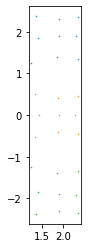

In [8]:
def points_on_surface(ray_table, geometry, i, fn):
    surf = geometry[i]
    field_nums = ray_table[0, :, 3, 0]
    keep = field_nums == fn
    x = np.sum(ray_table[i, keep, 0, :]*surf['x_axis'][np.newaxis, :], axis = 1)
    y = np.sum(ray_table[i, keep, 0, :]*surf['y_axis'][np.newaxis, :], axis = 1)
    return x, y

last = len(geometry) - 1
for i in range(3):
    xa, ya = points_on_surface(ray_table, geometry, -1, i)
    plt.plot(xa, ya, ls = 'none', marker = '.', markersize = 1)
    print(i, np.std(ya))
plt.gca().set_aspect("equal")

Now a crude merit function, just the RMS Y of each field. The merit function has to rebuild the geometry each time because its parameters are changing. But it shouldn't rebuild the ray table. The reason is that the ray table has to stay constant. Randomizing the rays at each iteration makes the merit function non-differentiable, and the minimization process less robust.

The graphing functions are in there, so the graphs can reflect the same design as what the optimize function spits out.

In [13]:
def merit_function(r, draw1 = False, draw2 = False):
    surface_list = [
        {'surf': 'dummy', 'dist': 20, 'draw_radius': 10},
        {'surf': 'conic', 'c': 1/r[0], 'k': 0, 'material': 'N-BK7', 'dist': 5, 'draw_radius': 10},
        {'surf': 'conic', 'c': -1/r[1], 'k': 0, 'dist': 5, 'draw_radius': 10},
        {'surf': 'conic', 'c': 1/r[1], 'k': 0, 'material': 'N-BK7', 'dist': 5, 'draw_radius': 10},
        {'surf': 'conic', 'c': -1/r[0], 'k': 0, 'dist': 20, 'draw_radius': 10},
        {'surf': 'dummy', 'dist': 20, 'draw_radius': 10}
    ]
    geometry = rtt.build_geometry(surface_list)
    rtt.trace_rays(ray_table, geometry)
    merit = 0
    for i in range(3):
        xa, ya = points_on_surface(ray_table, geometry, -1, i)
        if draw2:
            plt.plot(xa, ya, marker = '.', markersize = 1, linestyle = 'none')
        merit = merit + np.std(ya)**2
    if draw1:
        axd = rtd.new_plot(['y'], figsize = (10, 10))
        rtd.plot_faces(axd, geometry)
        rtd.plot_rays(axd, geometry, ray_table)
        
    return merit
    
merit_function([20, 20])

0.49168719823365253

Finally I'm just going to throw the **scipy.optimize.minimize()** function at it with no options!

In [11]:
m = minimize(merit_function, [22, 22])
m

      fun: 0.004711945186894197
 hess_inv: array([[250724.24870065, -41270.36814242],
       [-41270.36814242,   6799.94522812]])
      jac: array([-1.16904266e-06, -6.58637146e-06])
  message: 'Optimization terminated successfully.'
     nfev: 192
      nit: 46
     njev: 64
   status: 0
  success: True
        x: array([37.21202479, 16.65976719])

These are the "after" pictures.

Text(0.5, 1.0, 'Yay, it optimizes!')

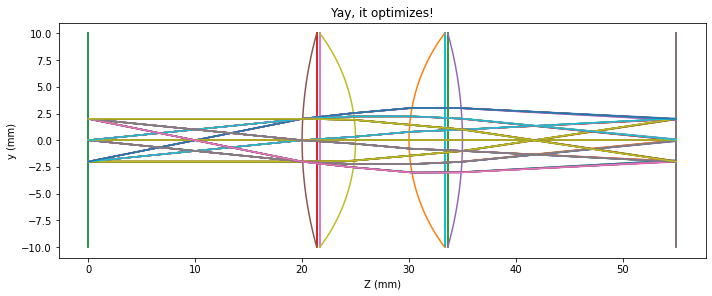

In [14]:
merit_function(m.x, draw1 = True)
plt.title('Yay, it optimizes!')

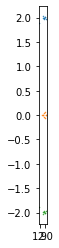

In [15]:
merit_function(m.x, draw2 = True)
plt.gca().set_aspect("equal")